This notebooks covers:
1. How to prepare environment (prepare simulation environment and GraspMAS environment)
2. Run GraspMAS to generate rectangle grasp pose
3. Convert rectangle grasp pose to 6DoF grasp pose
4. Manipulation Panda Arm given 6DoF grasp pose 

## Prepare environment

In [1]:
import multiprocessing as mp
import os
from copy import deepcopy
import time
import argparse
import gymnasium as gym
import numpy as np
from tqdm import tqdm
import os.path as osp
from mani_skill.utils.wrappers.record import RecordEpisode
import random
import matplotlib.pyplot as plt
from mani_skill.examples.motionplanning.panda.motionplanner import PandaArmMotionPlanningSolver
import torch
from IPython.display import HTML
from pathlib import Path
from IPython.display import Video
from mani_skill.utils import common

## Set up Table-top environment and motion planner

In [16]:
env_id = "PickSingleYCB-v1" ## set up environment, could be PickSingleYCB-v1 or PickClutterYCB-v1
env = gym.make(
    env_id,
    obs_mode='rgbd',
    control_mode="pd_joint_pos",
    render_mode="rgb_array",
    reward_mode=None,
    sensor_configs=dict(shader_pack='default'),
    human_render_camera_configs=dict(shader_pack='default'),
    viewer_camera_configs=dict(shader_pack='default'),
    sim_backend='gpu',
    enable_shadow=True,
    # obj_list=["030_fork"] ## object list, could be any object in YCB dataset
)

env = RecordEpisode(
    env,
    output_dir='simulated_demo/pick_YCB_Single',
    save_trajectory=False,
    trajectory_name='abc', save_video=True,
    source_type="motionplanning",
    source_desc="motionplanning solution PickSingleYCB-V1",
    video_fps=20,
    save_on_reset=False
)

### Visualize observation

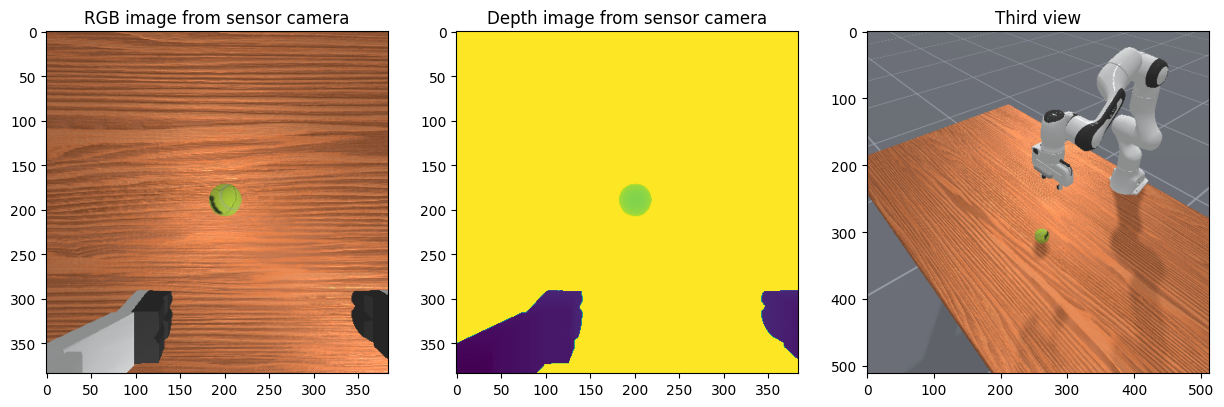

In [15]:
seed = 0 # seed control the object data
obs, _ = env.reset(seed=seed)
rgb = obs['sensor_data']['hand_camera']['rgb'].cpu().squeeze().numpy()
depth = obs['sensor_data']['hand_camera']['depth'].cpu().squeeze().numpy()
third_view = env.render_rgb_array().squeeze().cpu().numpy()


plt.figure(figsize=(15, 10))
plt.subplot(1,3,1)
# plt.axis('off')
plt.title('RGB image from sensor camera')
plt.imshow(rgb)

plt.subplot(1,3,2)
# plt.axis('off')
plt.title('Depth image from sensor camera')
plt.imshow(depth)

plt.subplot(1,3,3)
# plt.axis('off')
plt.title('Third view')
plt.imshow(third_view)
plt.show()


## 2D Grasp pose detection

### Full pipeline - Close loop with Planner, Coder and Observer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from PIL import Image
from agents.graspmas import GraspMAS
import warnings
warnings.filterwarnings('ignore')
import asyncio

========== Round 0 ==========


----- Thought ----- 
I need to locate the tennis ball in the image first. Once identified, I will compute the optimal grasp pose for the tennis ball.
----- Plan ----- 
Step 1: Find the tennis ball in the image.
Step 2: Calculate the grasp pose for the identified tennis ball.
----- Code ----- 
def execute_command(image):
    image_patch = ImagePatch(image)
    tennis_ball_patches = image_patch.find("tennis ball")
    grasp_pose = image_patch.grasp_detection(tennis_ball_patches[0])
    return grasp_pose
Executing code...
Grasp Pose Visualization saved at: imgs/grasp_pose_visualization.png
----- Observation ----- 
The grasp pose targets the center of a cylindrical object effectively and appears to be physically plausible as it avoids any fragile or sensitive regions. The alignment seems appropriate for a secure grasp.
========== Round 1 ==========
----- Thought ----- 
The grasp pose for the tennis ball has been validated as effective and safe. There is no need for further modifications si

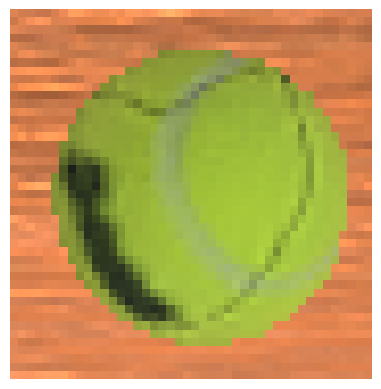

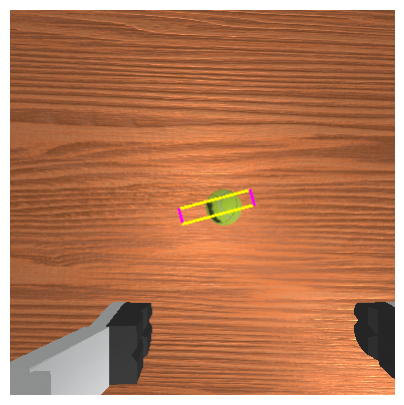

In [15]:
graspmas = GraspMAS(api_file='api.key', max_round=5)
# with warnings.catch_warnings():
# warnings.simplefilter("ignore")
async def run_query(query, image):
    return await graspmas.query(query, image)

query = "Grasp the tennis ball."
image_path = '/LOCAL2/anguyen/faic/quang/GraspAgentic/imgs/query_image.png'
save_path, grasp_2d = await run_query(query, image_path)

### Using Open-loop with Only Coder

In [ ]:
import matplotlib.pyplot as plt
import torch
import base64

from prompt import planner_prompt_v3
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")
from PIL import Image
from grasp.utils import *
from prompt import code_prompt_v2, code_prompt
import os
from openai import OpenAI
from image_patch import ImagePatch, OPENAI_CLIENT
api_file = os.path.join('api.key')
with open(api_file) as f:
    api_key = f.readline().splitlines()
OPENAI_CLIENT = OpenAI(api_key=api_key[0])

In [5]:
query = 'Grasp the the tennis ball.'
fewshot_examples = code_prompt.example_context
prompt = code_prompt.context.format(query=query, example=fewshot_examples)
input_message = [
    {"role": "system", "content": "Only answer with a function starting def execute_command."},
    {"role": "user", "content": prompt},
]

response = OPENAI_CLIENT.chat.completions.create(
    model="gpt-4o-mini",
    messages=input_message,
    temperature=0,
    max_tokens=1000,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=2.0,
    stop=["\"\"\""])

response_message = response.choices[0].message.content
code = '\n'.join(response_message.split('\n')[1:-1]).replace('\n    \n', '\n')
print("Code:\n",code)

Code:
 def execute_command(image):
    image_patch = ImagePatch(image)
    tennis_ball_patches = image_patch.find("tennis ball")
    grasp_pose = image_patch.grasp_detection(tennis_ball_patches[0])
    return grasp_pose


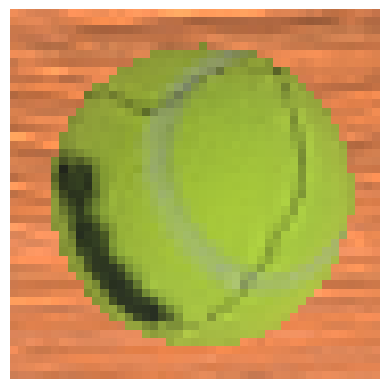

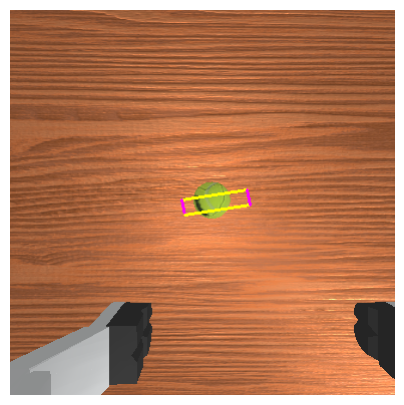

In [13]:
exec(code, globals())
grasp_2d = execute_command(rgb)
if grasp_2d is None:
    print("No grasp pose found.")
else:
    visualize_grasp_pose(np.array(rgb), grasp_2d)

## Compute 6DoF grasp pose from 2D grasp pose and depth image

In [7]:
## set up motion planner 
planner = PandaArmMotionPlanningSolver(
        env,
        debug=False,
        vis=False,
        base_pose=env.unwrapped.agent.robot.pose,
        visualize_target_grasp_pose=False,
        print_env_info=False,
    )

In [8]:
# printing rectangle grasp pose (confidence, x, y, width, height, angle)
print(grasp_2d)

[0.9995827078819275, 205.58015794020434, 191.87278395432693, 65.84277578500601, 14.980064392089844, 171.16812133789062]


In [9]:
# show camera parameters
obs["sensor_param"]["hand_camera"]

{'extrinsic_cv': tensor([[[ 9.2738e-05, -1.0000e+00, -3.2763e-07,  2.0004e-02],
          [-1.0000e+00, -9.2738e-05,  9.6679e-05, -2.4234e-02],
          [-9.6679e-05,  3.1867e-07, -1.0000e+00,  3.8544e-01]]],
        device='cuda:0'),
 'cam2world_gl': tensor([[[ 9.2685e-05,  1.0000e+00,  9.6685e-05, -2.4198e-02],
          [-1.0000e+00,  9.2685e-05, -3.3302e-07,  2.0001e-02],
          [-3.4198e-07, -9.6685e-05,  1.0000e+00,  3.8545e-01],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
        device='cuda:0'),
 'intrinsic_cv': tensor([[[192.,   0., 192.],
          [  0., 192., 192.],
          [  0.,   0.,   1.]]], device='cuda:0')}

In [ ]:
_, x, y, w, h, angle = map(round, grasp_2d)
camera_params = obs["sensor_param"]['hand_camera']
K = camera_params['intrinsic_cv'][0].cpu().numpy()
fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]
z = depth[y, x]/1000  # depth at grasp center in meters

X = (x - cx) * z / fx
Y = (y - cy) * z / fy
Z = z
grasp_center_cam = np.array([X, Y, Z, 1])

extrinsic_cv = camera_params['extrinsic_cv'][0].cpu().numpy()
R = extrinsic_cv[:3, :3]  # 3x3 rotation matrix
t = extrinsic_cv[:3, 3]  # 3x1 translation vector

T_cam2world = np.eye(4)
T_cam2world[:3, :3] = R.T
T_cam2world[:3, 3] = -R.T @ t  # Adjust translation to world frame
# print(T_cam2world)
grasp_center_world = T_cam2world @ grasp_center_cam
# print("Grasp center in world coordinates:", grasp_center_world)
grasp_center_world = grasp_center_world[:3]  # Convert to 3D point

angle = (angle-90) * np.pi / 180  # Convert angle to radians and adjust
closing_cam = np.array([np.cos(angle), np.sin(angle), 0])
# closing_world = R_cam2world @ closing_cam
approaching = np.array([0, 0, -1])
grasp_6d = env.agent.build_grasp_pose(approaching, closing_cam, grasp_center_world)
print(grasp_6d)

### Control the robot arm

In [ ]:
import sapien
from mani_skill.utils.structs import Actor, Pose

# -------------------------------------------------------------------------- #
# Move the Reach Pose
# -------------------------------------------------------------------------- #
reach_pose = grasp_6d * sapien.Pose([0, 0, -0.05])
planner.move_to_pose_with_screw(reach_pose)

# -------------------------------------------------------------------------- #
# Grasp
# -------------------------------------------------------------------------- #

planner.move_to_pose_with_screw(grasp_6d * sapien.Pose([0.005, 0, 0.015]))
planner.close_gripper()

# -------------------------------------------------------------------------- #
# Move to goal pose
# -------------------------------------------------------------------------- #
# goal_pose = sapien.Pose(env.goal_site.pose.sp.p, grasp_6d.q)
goal_pose = grasp_6d * sapien.Pose([0, 0, -0.4])
env.goal_pos = torch.from_numpy(goal_pose.p)
env.goal_site.set_pose(Pose.create_from_pq(env.goal_pos))
res = planner.move_to_pose_with_screw(goal_pose)

planner.close()

### Show video

In [12]:
env.flush_video()
env.close()
Video("simulated_demo/pick_YCB_Single/0.mp4")